In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Always nice for plots in notebooks
%matplotlib inline

# Project folder (where your .py and data live)
PROJECT_DIR = Path.cwd()

# Main DfT file and your Sheffield subset file (adjust names if needed)
RAW_DFT_CSV  = PROJECT_DIR / "dft_traffic_counts_aadf.csv"
DF_SHEFF_CSV = PROJECT_DIR / "df_sheff.csv"

print("Project dir:", PROJECT_DIR)
print("Raw DfT exists:", RAW_DFT_CSV.exists())
print("Sheffield subset exists:", DF_SHEFF_CSV.exists())


Project dir: C:\Users\manda\OneDrive\Documents\AI Traffic - Jupyter\eda
Raw DfT exists: True
Sheffield subset exists: True


In [3]:
if DF_SHEFF_CSV.exists():
    df_sheff = pd.read_csv(DF_SHEFF_CSV)
else:
    # Load full DfT AADF data
    df = pd.read_csv(RAW_DFT_CSV, low_memory=False)# Load full DfT AADF data
    df.columns = [c.strip().lower() for c in df.columns]

    SHEFF_CODE = "E08000019"  # Sheffield

    
    keep_cols = [
        "count_point_id","year","local_authority_name","local_authority_code", # Keep only useful columns 
        "road_name","road_type","road_category",
        "all_motor_vehicles","latitude","longitude"
    ]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    
    df["count_point_id"] = df["count_point_id"].astype(str)
    df["year"] = pd.to_numeric(df["year"], errors="coerce")# Basic cleaning
    df["all_motor_vehicles"] = pd.to_numeric(df["all_motor_vehicles"], errors="coerce")
    df = df.dropna(subset=["all_motor_vehicles"])

    
    df_sheff = df[
        (df["local_authority_code"] == SHEFF_CODE) |
        (df["local_authority_name"].astype(str).str.fullmatch("Sheffield", na=False))# Filter to Sheffield
    ].copy()

    
    if "road_type" in df_sheff.columns:
        df_sheff = df_sheff[~df_sheff["road_type"].str.contains("Minor", case=False, na=False)]# Optionally drop minor roads

    # Save for reuse
    df_sheff.to_csv(DF_SHEFF_CSV, index=False)# Save for reuse
    print("Saved Sheffield subset to:", DF_SHEFF_CSV)

# Quick check
print("Sheffield subset shape:", df_sheff.shape)# Quick check
df_sheff.head()


Sheffield subset shape: (2380, 10)


,count_point_id,year,local_authority_name,local_authority_code,road_name,road_type,road_category,all_motor_vehicles,latitude,longitude
0,6565,2000,Sheffield,E08000019,A57,Major,PA,6200,53.379922,-1.550482
1,6565,2001,Sheffield,E08000019,A57,Major,PA,6245,53.379922,-1.550482
2,6565,2002,Sheffield,E08000019,A57,Major,PA,6051,53.379922,-1.550482
3,6565,2003,Sheffield,E08000019,A57,Major,PA,6192,53.379922,-1.550482
4,6565,2004,Sheffield,E08000019,A57,Major,PA,6206,53.379922,-1.550482


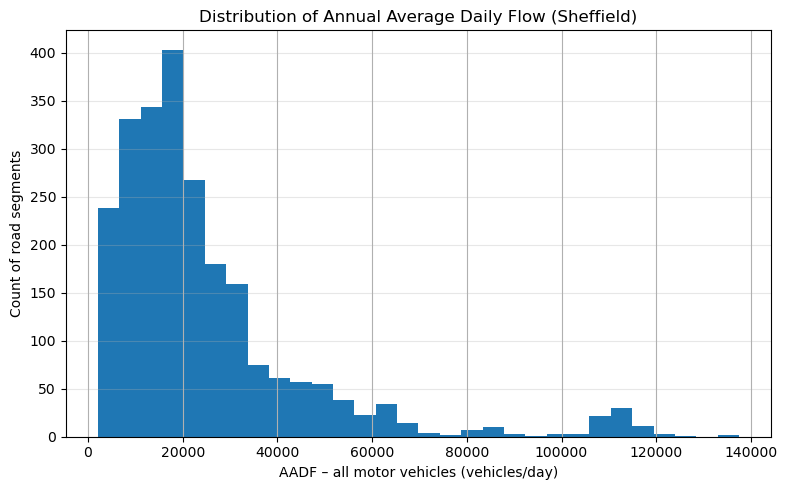

In [3]:
plt.figure(figsize=(8, 5))
df_sheff["all_motor_vehicles"].hist(bins=30)
plt.xlabel("AADF – all motor vehicles (vehicles/day)")
plt.ylabel("Count of road segments")
plt.title("Distribution of Annual Average Daily Flow (Sheffield)")
plt.grid(axis="y", alpha=0.3)

# Save for dissertation (high quality)
plt.tight_layout()
plt.savefig("fig_ch3_flow_hist_sheffield.png", dpi=300)
plt.show()


In [4]:
import numpy as np

# 1) Mean daily flow across Sheffield count points
mean_daily_flow = df_sheff["all_motor_vehicles"].mean()
print("Mean daily AADF (all motor vehicles) in Sheffield:", mean_daily_flow)

# 2) Realistic 24-hour profile (relative weights)
hourly_weights = np.array([
    0.01, 0.005, 0.005, 0.005,   # 00–03
    0.01, 0.03, 0.06, 0.09,      # 04–07
    0.10, 0.08, 0.06, 0.05,      # 08–11
    0.05, 0.05, 0.06, 0.07,      # 12–15
    0.09, 0.10, 0.07, 0.04,      # 16–19
    0.03, 0.02, 0.01, 0.005      # 20–23
], dtype=float)

hourly_weights = hourly_weights / hourly_weights.sum()

hours = np.arange(24)
hourly_flow = mean_daily_flow * hourly_weights

df_hourly = pd.DataFrame({"hour": hours, "flow": hourly_flow})
df_hourly.head()


Mean daily AADF (all motor vehicles) in Sheffield: 24838.059663865548


,hour,flow
0,0,225.800542
1,1,112.900271
2,2,112.900271
3,3,112.900271
4,4,225.800542


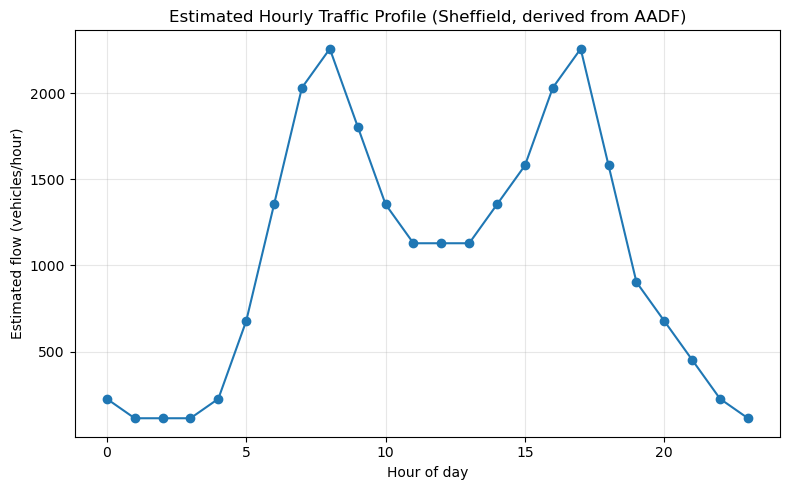

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(df_hourly["hour"], df_hourly["flow"], marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Estimated flow (vehicles/hour)")
plt.title("Estimated Hourly Traffic Profile (Sheffield, derived from AADF)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_ch3_hourly_flow_sheffield.png", dpi=300)
plt.show()


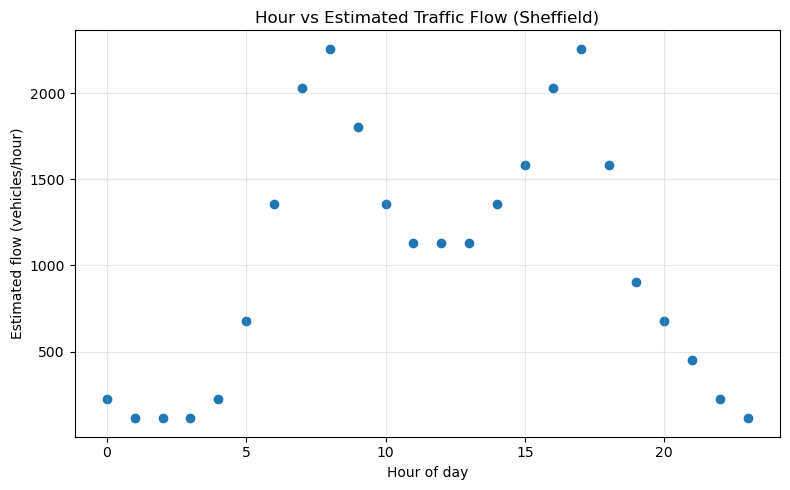

In [6]:
plt.figure(figsize=(8, 5))
plt.scatter(df_hourly["hour"], df_hourly["flow"])
plt.xlabel("Hour of day")
plt.ylabel("Estimated flow (vehicles/hour)")
plt.title("Hour vs Estimated Traffic Flow (Sheffield)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_ch3_hour_vs_flow_scatter_sheffield.png", dpi=300)
plt.show()


Vehicle type columns found: ['all_motor_vehicles', 'cars_and_taxis', 'all_hgvs', 'buses_and_coaches', 'pedal_cycles', 'two_wheeled_motor_vehicles']


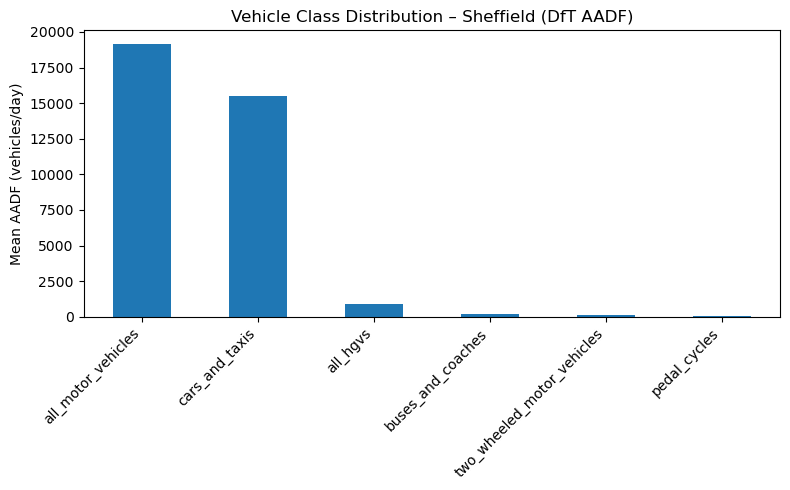

In [11]:
# Try to build a simple vehicle-class distribution from the raw DfT file
df_full = pd.read_csv(RAW_DFT_CSV, low_memory=False)
df_full.columns = [c.strip().lower() for c in df_full.columns]

SHEFF_CODE = "E08000019"
df_full_sheff = df_full[
    (df_full["local_authority_code"] == SHEFF_CODE) |
    (df_full["local_authority_name"].astype(str).str.fullmatch("Sheffield", na=False))
].copy()

# Common vehicle-type columns in DfT AADF (we'll keep only those that actually exist)
candidate_cols = [
    "all_motor_vehicles",
    "cars_and_taxis",
    "all_hgvs",
    "all_lgvs",
    "buses_and_coaches",
    "pedal_cycles",
    "two_wheeled_motor_vehicles",
]

veh_cols = [c for c in candidate_cols if c in df_full_sheff.columns]
print("Vehicle type columns found:", veh_cols)

# Compute mean AADF per vehicle type for Sheffield
veh_means = df_full_sheff[veh_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
veh_means.plot(kind="bar")
plt.ylabel("Mean AADF (vehicles/day)")
plt.title("Vehicle Class Distribution – Sheffield (DfT AADF)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("fig_ch3_vehicle_class_distribution_sheffield1.png", dpi=300)
plt.show()


Route file exists: True
Total vehicles in route file: 13628


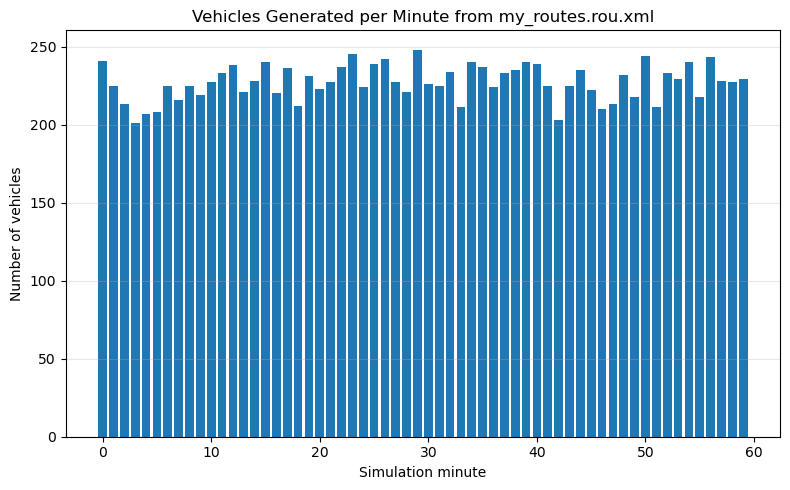

In [8]:
import xml.etree.ElementTree as ET

# Adjust this if your .rou file is in a different folder
ROUTE_FILE = PROJECT_DIR.parent / "my_routes.rou.xml"
print("Route file exists:", ROUTE_FILE.exists())

tree = ET.parse(ROUTE_FILE)
root = tree.getroot()

depart_times = []
for veh in root.iter("vehicle"):
    dep = veh.get("depart")
    if dep is not None:
        depart_times.append(float(dep))

print("Total vehicles in route file:", len(depart_times))

# Put into a DataFrame
df_rou = pd.DataFrame({"depart_time": depart_times})

# Convert depart time (seconds) → minute bucket
df_rou["minute"] = (df_rou["depart_time"] // 60).astype(int)

veh_per_min = df_rou.groupby("minute")["depart_time"].count().reset_index(name="num_vehicles")

plt.figure(figsize=(8, 5))
plt.bar(veh_per_min["minute"], veh_per_min["num_vehicles"])
plt.xlabel("Simulation minute")
plt.ylabel("Number of vehicles")
plt.title("Vehicles Generated per Minute from my_routes.rou.xml")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("fig_ch3_vehicles_per_minute_routes.png", dpi=300)
plt.show()


In [9]:
import xml.etree.ElementTree as ET

ROUTE_FILE = PROJECT_DIR.parent / "my_routes.rou.xml"
tree = ET.parse(ROUTE_FILE)
root = tree.getroot()

od_pairs = []

for veh in root.iter("vehicle"):
    # Case 1: route nested inside vehicle
    route_el = veh.find("route")
    if route_el is not None and route_el.get("edges"):
        edges = route_el.get("edges").split()
    else:
        # Case 2: vehicle refers to a predefined route by id
        route_id = veh.get("route")
        if route_id is None:
            continue
        route_def = root.find(f".//route[@id='{route_id}']")
        if route_def is None or route_def.get("edges") is None:
            continue
        edges = route_def.get("edges").split()

    if len(edges) >= 2:
        origin = edges[0]
        dest   = edges[-1]
        od_pairs.append((origin, dest))

# Build DataFrame
df_od = pd.DataFrame(od_pairs, columns=["origin_edge", "dest_edge"])

od_summary = (
    df_od.value_counts()
        .reset_index(name="num_vehicles")
        .sort_values("num_vehicles", ascending=False)
)

print("OD summary (top 10):")
display(od_summary.head(10))

print("\nTotal OD pairs:", len(od_summary))
print("Total vehicles with valid OD:", len(df_od))


OD summary (top 10):


,origin_edge,dest_edge,num_vehicles
0,315129223#4,-15833384#1,63
1,315129218#1,-15833384#1,59
2,164073716#1,821520603,55
3,107445426#1,-974103232#0,54
4,315129223#3,800859756#2,53
5,315129223#3,800859756#1,51
6,315129223#2,315129223#3,51
8,-974103232#1,-974103232#0,50
7,164073716#1,107445426#0,50
9,107445426#0,-974103232#1,50



Total OD pairs: 351
Total vehicles with valid OD: 12145


Vehicle type columns found: ['cars_and_taxis', 'all_hgvs', 'buses_and_coaches', 'pedal_cycles', 'two_wheeled_motor_vehicles']


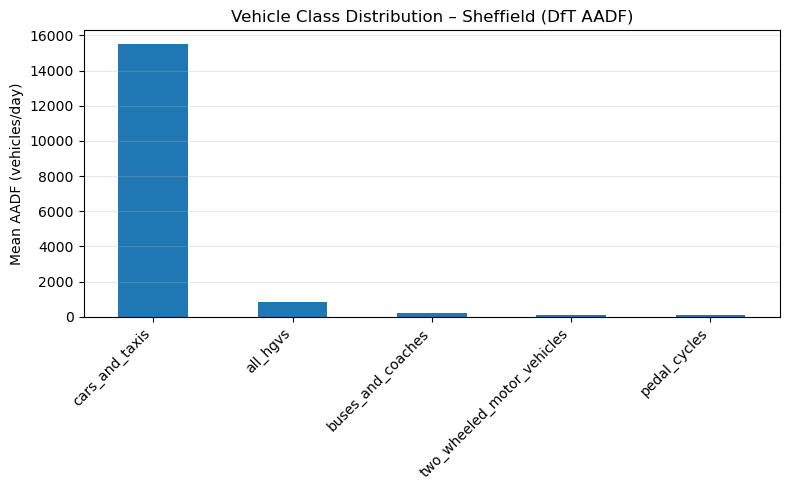

In [10]:
# Load full DfT file (again, but this time for vehicle classes)
df_full = pd.read_csv(RAW_DFT_CSV, low_memory=False)
df_full.columns = [c.strip().lower() for c in df_full.columns]

SHEFF_CODE = "E08000019"
df_full_sheff = df_full[
    (df_full["local_authority_code"] == SHEFF_CODE) |
    (df_full["local_authority_name"].astype(str).str.fullmatch("Sheffield", na=False))
].copy()

# Candidate vehicle-type columns in DfT AADF
candidate_cols = [
    "cars_and_taxis",
    "all_lgvs",
    "all_hgvs",
    "buses_and_coaches",
    "pedal_cycles",
    "two_wheeled_motor_vehicles",
]

veh_cols = [c for c in candidate_cols if c in df_full_sheff.columns]
print("Vehicle type columns found:", veh_cols)

veh_means = df_full_sheff[veh_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
veh_means.plot(kind="bar")
plt.ylabel("Mean AADF (vehicles/day)")
plt.title("Vehicle Class Distribution – Sheffield (DfT AADF)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("fig_ch3_vehicle_class_distribution_sheffield.png", dpi=300)
plt.show()


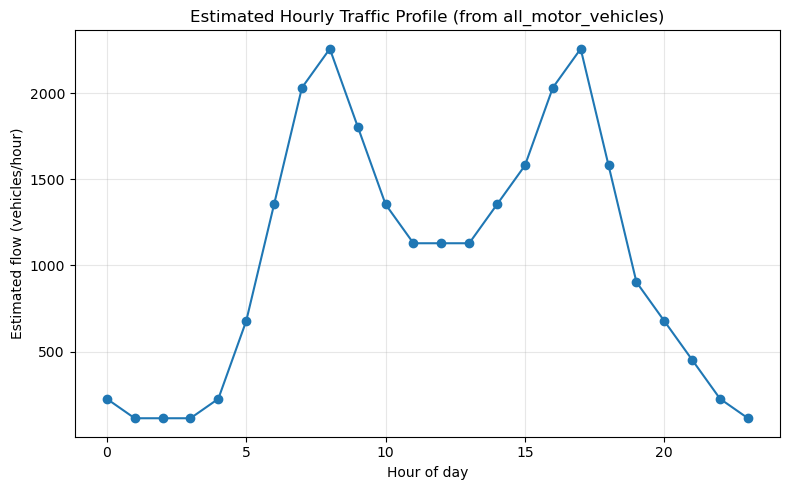

In [6]:
import numpy as np

# Build hourly profile if not already done
mean_daily_flow = df_sheff["all_motor_vehicles"].mean()

hourly_weights = np.array([
    0.01, 0.005, 0.005, 0.005,   # 00–03
    0.01, 0.03, 0.06, 0.09,      # 04–07
    0.10, 0.08, 0.06, 0.05,      # 08–11
    0.05, 0.05, 0.06, 0.07,      # 12–15
    0.09, 0.10, 0.07, 0.04,      # 16–19
    0.03, 0.02, 0.01, 0.005      # 20–23
], dtype=float)
hourly_weights = hourly_weights / hourly_weights.sum()

hours = np.arange(24)
hourly_flow = mean_daily_flow * hourly_weights

df_hourly = pd.DataFrame({"hour": hours, "flow": hourly_flow})

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_hourly["hour"], df_hourly["flow"], marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Estimated flow (vehicles/hour)")
plt.title("Estimated Hourly Traffic Profile (from all_motor_vehicles)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_ch3_hourly_flow_from_all_motor_vehicles.png", dpi=300)
plt.show()



In [10]:
if "year" in df_sheff.columns:
    yearly_mean = (
        df_sheff
        .dropna(subset=["year"])
        .groupby("year")["all_motor_vehicles"]
        .mean()
        .reset_index()
    )

    plt.figure()
    plt.plot(yearly_mean["year"], yearly_mean["all_motor_vehicles"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Mean AADF (all motor vehicles)")
    plt.title("Trend of Mean AADF in Sheffield Over Time")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    trend_png = PROJECT_DIR / "fig_ch3_mean_aadf_trend_sheffield.png"
    plt.savefig(trend_png, dpi=300)
    print("Saved:", trend_png)

    plt.close()


Saved: C:\Users\manda\OneDrive\Documents\AI Traffic - Jupyter\eda\fig_ch3_mean_aadf_trend_sheffield.png
